# NARMA10 DFR

## Import Packages

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import shape
from numpy.core.function_base import linspace

## Define Mackey-Glass Transfer Function

[Mackey-Glass equation on Scholarpedia](http://www.scholarpedia.org/article/Mackey-Glass_equation)

$$
y = \frac{2 \times x}{0.8 + 0.2(2.1 \times x)^{10}}
$$

In [146]:
def mg(x):

    a = 2
    b = 0.8
    c = 0.2
    d = 2.1
    p = 10

    return (a * x) / (b + c * np.power( (d * x), p) )

## NARMA10 Sample Generation

In [147]:
rng = np.random.default_rng(0)

# NARMA10
def narma10_create(inLen):

    # Compute the random uniform input matrix
    inp = 0.5*rng.random(inLen)

    # Compute the target matrix
    tar = np.zeros(inLen)

    for k in range(10,(inLen - 1)):
        tar[k+1] = 0.3 * tar[k] + 0.05 * tar[k] * np.sum(tar[k-9:k]) + 1.5 * inp[k] * inp[k - 9] + 0.1
    
    return (inp, tar)

## NARMA10 Samples

In [148]:
init_samples = 200
train_samples = 6000
test_samples = 14000

num_samples = init_samples + train_samples + test_samples

x, y = narma10_create(num_samples)
y_train = y[init_samples:init_samples+train_samples]
y_test = y[init_samples + train_samples:init_samples+train_samples+test_samples]

## DFR Parameters

In [149]:
N = 50
gamma = 0.5
eta = 0.4
LAST_NODE = N - 1
reg = 1e-8

## Mask Generation

In [150]:
mask = rng.uniform(-0.5,0.5,N)

masked_samples = np.empty((num_samples,N))
for i in range(num_samples):
    masked_samples[i] = mask * x[i]

# DFR Training Initialization

In [151]:
reservoir = np.zeros(N)
reservoir_history = np.zeros((train_samples,N))
for i in range(init_samples):
    for j in range(N):
        g_i = mg(gamma * masked_samples[i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

## DFR Training Data Stage

In [152]:
y_hat = np.zeros(train_samples)
for i in range(train_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[i + init_samples][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

## Calculate DFR Readout Weights using Ridge Regression

$$
W = \frac{\hat{y} \cdot X}{X^{T} \cdot X + \lambda I}
$$

In [153]:
W = np.dot(np.dot(y_train,reservoir_history),np.linalg.inv((np.dot(reservoir_history.T,reservoir_history)) + reg * np.eye(N)))

## Training Data Accuracy

Ridge Regression NRMSE:	0.20014083528245485


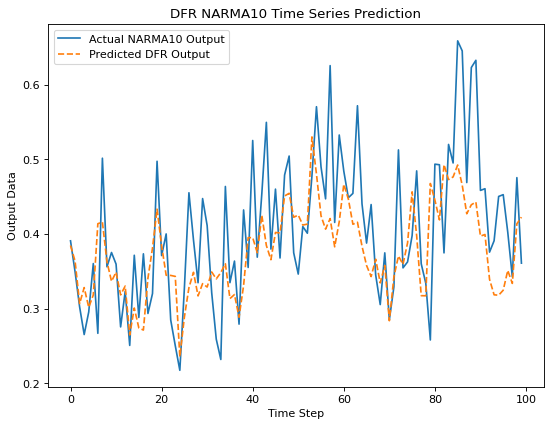

In [154]:
y_hat_reg = reservoir_history.dot(W)
loss = (np.linalg.norm(y_train - y_hat_reg) / np.linalg.norm(y_train))
print(f"Ridge Regression NRMSE:\t{loss}")

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(y_train[0:100],label="Actual NARMA10 Output")
plt.plot(y_hat_reg[0:100],'--',label="Predicted DFR Output")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Output Data")
plt.title("DFR NARMA10 Time Series Prediction")
plt.show()

## DFR Testing Data Stage

In [155]:
reservoir_history = np.zeros((test_samples,N))
y_hat = np.zeros(test_samples)
for i in range(test_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[i + init_samples + train_samples][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

## Testing Data Accuracy

Ridge Regression NRMSE:	0.1984508382751022


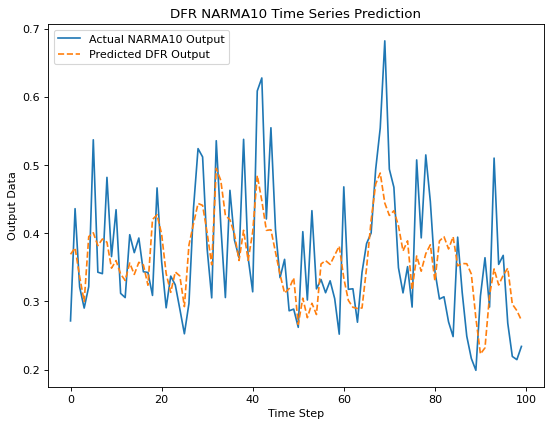

In [157]:
y_hat_reg = reservoir_history.dot(W)
loss = (np.linalg.norm(y_test - y_hat_reg) / np.linalg.norm(y_test))
print(f"Ridge Regression NRMSE:\t{loss}")

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(y_test[0:100],label="Actual NARMA10 Output")
plt.plot(y_hat_reg[0:100],'--',label="Predicted DFR Output")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Output Data")
plt.title("DFR NARMA10 Time Series Prediction")
plt.show()